In [75]:
from typing import Tuple, List
import json
from prettytable import PrettyTable
import pandas as pd
import numpy as np
from numpy.random import Generator, default_rng
from numpy.typing import NDArray
from dataclasses import dataclass
from scipy import stats, special, optimize
# from scipy.stats import beta
from scipy.spatial.distance import jensenshannon

In [ ]:
cls_name2id = {
    'FinancialBERT': 'FIB',
    'lxyuan_DistilBert': 'DSS',
    'DistilBert': 'DSS',
    'ollama3.2': 'LL3',
    'Yolov8': 'VO8',
    'DETR': 'DTR',
    'LLaVA': 'LLV'
}

model_name2id = {
    'Llama-3.3-70B': 'L370B',
    'llama3-3': 'L370B',
    'Llama-2-7B': 'L27B',
    'llama2': 'L27B',
    'Mistral-7B': 'Mi7B',
    'mistral': 'Mi7B',
    'Stable Diffusion 3.5': 'SD35',
    'Stable Cascade': 'StCa',
    'FLUX.1-dev': 'FLX1'
}

In [77]:


@dataclass(frozen=True)
class BetaComponent:
    a: float
    b: float
    weight: float

    def mean(self) -> float:
        return stats.beta.mean(a=self.a, b=self.b)

    def var(self) -> float:
        return stats.beta.var(a=self.a, b=self.b)

    def sample(self, n_samples: int, rng: int | Generator) -> NDArray[float]:
        return stats.beta.rvs(a=self.a, b=self.b, size=n_samples, random_state=rng)

    def pdf(self, x: NDArray[float]) -> NDArray[float]:
        return stats.beta.pdf(x, a=self.a, b=self.b)

    def cdf(self, x: NDArray[float]) -> NDArray[float]:
        return stats.beta.cdf(x, a=self.a, b=self.b)

    def json(self) -> dict:
        return {
            "a": float(self.a),
            "b": float(self.b),
            "weight": float(self.weight),
        }

    @classmethod
    def from_json(cls, d: dict):
        return cls(**d)


@dataclass(frozen=True)
class BetaMixture:
    components: List[BetaComponent]

    def __post_init__(self):
        total_weight = np.sum([c.weight for c in self.components])
        if not np.allclose(total_weight, 1.):
            raise ValueError(f"component weights should sum to 1., got sum {float(total_weight):.3f}")

    def mean(self) -> float:
        return np.sum([c.weight*c.mean() for c in self.components])

    def var(self) -> float:
        mu = self.mean()
        return np.sum([c.weight*(c.var() + (c.mean() - mu)**2) for c in self.components])

    def sample(self, n_samples: int, rng: int | Generator) -> NDArray[float]:
        rng = default_rng(rng)
        k = len(self.components)

        component_choice = rng.choice(
            a=np.arange(k),
            size=n_samples,
            replace=True,
            p=np.array([c.weight for c in self.components])
        )
        result = np.zeros_like(component_choice, dtype=float)
        for k_ in range(k):
            k_mask = component_choice == k_
            n_ = k_mask.sum()
            if n_ > 0:
                result[k_mask] = self.components[k_].sample(n_samples=n_, rng=rng)

        return result

    def pdf(self, x: NDArray[float]) -> NDArray[float]:
        return np.array([
           c.weight*c.pdf(x)
           for c in self.components
        ]).sum(axis=0)

    def cdf(self, x: NDArray[float]) -> NDArray[float]:
        return np.array([
            c.weight*c.cdf(x)
            for c in self.components
        ]).sum(axis=0)

    def json(self) -> dict:
        return {
            "components": [c.json() for c in self.components]
        }

    @classmethod
    def from_json(cls, d: dict):
        return cls(components=list(map(BetaComponent.from_json, d["components"])))



In [78]:
def js_beta(dist_p, dist_q):
    xs_upper = np.arange(1, 1001) / 1000
    xs_lower = np.arange(0, 1000) / 1000

    p = beta.cdf(xs_upper, dist_p.params.a, dist_p.params.b) - beta.cdf(xs_lower, dist_p.params.a, dist_p.params.b)
    q = beta.cdf(xs_upper, dist_q.params.a, dist_q.params.b) - beta.cdf(xs_lower, dist_q.params.a, dist_q.params.b)

    return jensenshannon(p, q, base=2)

In [79]:
def js_beta_mixture(dist_p, dist_q):
    xs_upper = np.arange(1, 1001) / 1000
    xs_lower = np.arange(0, 1000) / 1000

    p = dist_p.cdf(xs_upper) - dist_p.cdf(xs_lower)
    q = dist_q.cdf(xs_upper) - dist_q.cdf(xs_lower)
    
    return jensenshannon(p, q, base=2)


In [80]:
def pretty_print_latex(latex_str):
    lines = latex_str.replace(r" \\ ", r" \\" + "\n").splitlines()
    formatted_lines = []
    indent_level = 0
    for line in lines:
        if r"\begin" in line:
            formatted_lines.append(line)
            indent_level += 1
        elif r"\end" in line:
            indent_level -= 1
            formatted_lines.append(line)
        else:
            formatted_lines.append("    " * indent_level + line)
    return "\n".join(formatted_lines)

In [81]:
with open("../bcc_improved_results.json", 'r') as f:
    improved_results = json.load(f)

t = PrettyTable(['Generator', 'Classifier', 'Improved BCC'])


res = {}


for generator in improved_results:
    oracle_dist = BetaMixture.from_json(generator['human_sampled'])
    p_dist = BetaMixture.from_json(generator['bcc_improved'])

    js = js_beta_mixture(oracle_dist, p_dist)


    bcc = f'{round(js, 4)} / {"%.2E" % p_dist.var()}'

    g = model_name2id[generator['generator']]
    c = cls_name2id[generator['classifier']]

    res[f'{g}-{c}'] = bcc

    t.add_row([g, c, bcc])

t
        

Generator,Classifier,Improved BCC
L27B,LL3,0.3742 / 7.38E-02
L27B,FIB,0.269 / 4.57E-02
L27B,DSS,0.3567 / 7.25E-02
Mi7B,LL3,0.7404 / 9.03E-02
Mi7B,FIB,0.2328 / 6.34E-02
Mi7B,DSS,0.1956 / 6.53E-02
L370B,LL3,0.6098 / 4.70E-02
L370B,FIB,0.3306 / 2.64E-02
L370B,DSS,0.2131 / 3.76E-02


In [82]:
l = pretty_print_latex(t.get_latex_string())

print(l)

\begin{tabular}{ccc}
    Generator & Classifier & Improved BCC \\
    L27B & LL3 & 0.3742 / 7.38E-02 \\
    L27B & FIB & 0.269 / 4.57E-02 \\
    L27B & DSS & 0.3567 / 7.25E-02 \\
    Mi7B & LL3 & 0.7404 / 9.03E-02 \\
    Mi7B & FIB & 0.2328 / 6.34E-02 \\
    Mi7B & DSS & 0.1956 / 6.53E-02 \\
    L370B & LL3 & 0.6098 / 4.70E-02 \\
    L370B & FIB & 0.3306 / 2.64E-02 \\
    L370B & DSS & 0.2131 / 3.76E-02 \\
\end{tabular}


In [83]:
import pandas as pd
df = pd.read_json('tab_7_jensen-shannon.json', orient='records')

df = df[df['Task'] == 'Text']

df['Improved BCC'] = df.apply(lambda r: res[f"{r['Generator']}-{r['Classifier']}"], axis=1)

df[['Generator', 'Classifier', 'CC', 'BCC', 'Improved BCC']]

,Generator,Classifier,CC,BCC,Improved BCC
0,L370B,FIB,1.0 / 2.49E-05,0.162 / 1.14E-03,0.3306 / 2.64E-02
1,L370B,DSS,1.0 / 2.38E-05,0.0726 / 9.04E-04,0.2131 / 3.76E-02
2,L370B,LL3,0.9982 / 2.03E-05,0.1256 / 7.46E-04,0.6098 / 4.70E-02
3,L27B,FIB,1.0 / 2.49E-05,0.1305 / 1.19E-03,0.269 / 4.57E-02
4,L27B,DSS,0.9994 / 2.33E-05,0.3561 / 8.44E-04,0.3567 / 7.25E-02
5,L27B,LL3,0.9652 / 2.04E-05,0.1698 / 8.50E-04,0.3742 / 7.38E-02
6,Mi7B,FIB,1.0 / 2.30E-05,0.1255 / 1.25E-03,0.2328 / 6.34E-02
7,Mi7B,DSS,0.9995 / 2.42E-05,0.216 / 1.02E-03,0.1956 / 6.53E-02
8,Mi7B,LL3,0.94 / 2.09E-05,0.1944 / 9.79E-04,0.7404 / 9.03E-02


In [84]:
l = pretty_print_latex(t.get_latex_string())

print(l)

\begin{tabular}{ccc}
    Generator & Classifier & Improved BCC \\
    L27B & LL3 & 0.3742 / 7.38E-02 \\
    L27B & FIB & 0.269 / 4.57E-02 \\
    L27B & DSS & 0.3567 / 7.25E-02 \\
    Mi7B & LL3 & 0.7404 / 9.03E-02 \\
    Mi7B & FIB & 0.2328 / 6.34E-02 \\
    Mi7B & DSS & 0.1956 / 6.53E-02 \\
    L370B & LL3 & 0.6098 / 4.70E-02 \\
    L370B & FIB & 0.3306 / 2.64E-02 \\
    L370B & DSS & 0.2131 / 3.76E-02 \\
\end{tabular}


In [85]:
generator['generator'], generator['classifier']

('llama3-3', 'DistilBert')

In [86]:
oracle_dist = BetaMixture.from_json(generator['human_sampled'])
p_dist = BetaMixture.from_json(generator['bcc_improved'])

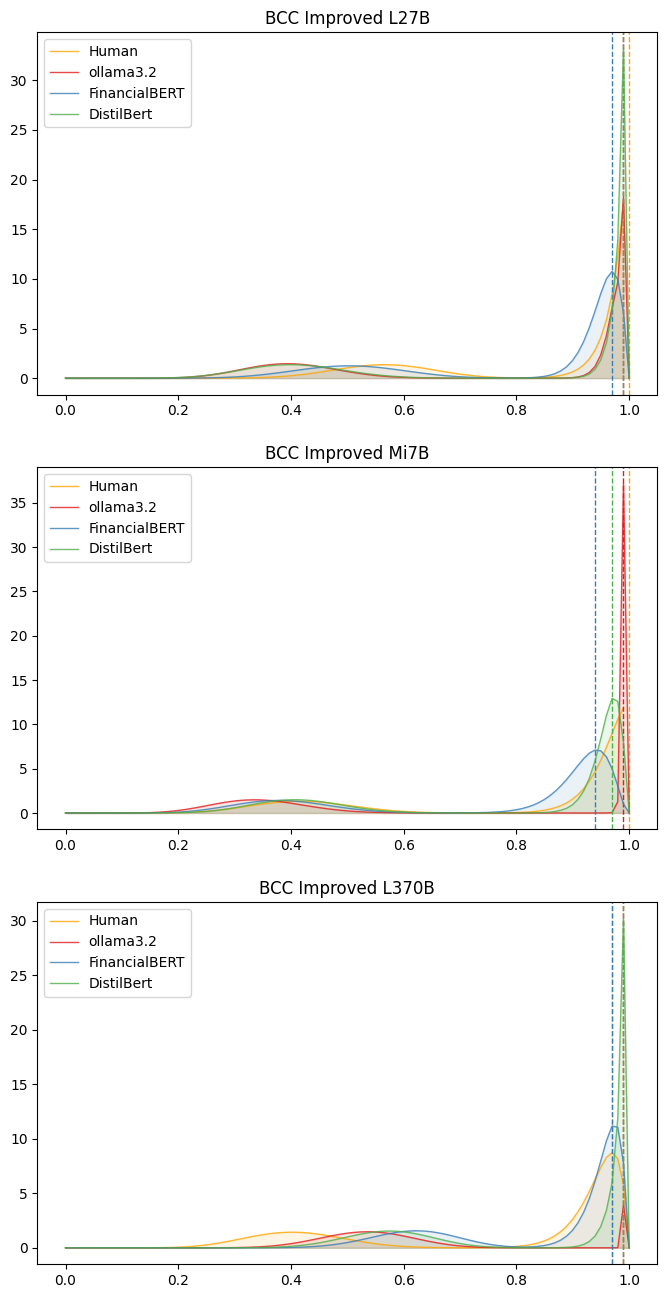

In [108]:

import matplotlib.pyplot as plt
from prettytable import PrettyTable

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Set1.colors)


def plot_beta(ax, beta: BetaMixture, label):
    x = np.linspace(0,1,100)
    pdf = beta.pdf(x)

    line, = ax.plot(x, pdf, lw=1, alpha=.8,color='orange' if label == 'Human' else None, label=label)
    ax.fill_between(x, pdf, color=line.get_color(), alpha=0.1)

    mode = x[beta.pdf(x).argmax()]
    ax.axvline(mode, color=line.get_color(), linestyle='--', lw=1)

fig = plt.figure(figsize=(8, 16))

generators = list(set([g['generator'] for g in improved_results]))

for idx, g in enumerate(generators):
    ax_1 = fig.add_subplot(len(generators), 1, idx+1)
    ax_1.set_title(f"BCC Improved {model_name2id[g]}")

    plot_beta(ax_1, oracle_dist, 'Human')

    for results in improved_results:
        if results['generator'] != g:
            continue

        oracle_dist = BetaMixture.from_json(results['human_sampled'])
        p_dist = BetaMixture.from_json(results['bcc_improved'])

        plot_beta(ax_1, p_dist, f"{results['classifier']}")
    
    ax_1.legend(loc='upper left')
